# Load Data

In [1]:
import pandas as pd

data = "/content/tweets.csv"
df = pd.read_csv(data)
df.head(5)


,company,tweet,sentiment
0,$ICICIBANK.NSE,$ICICIBANK.NSE Trade in action & Very close to...,Bullish
1,$ICICIBANK.NSE,$ICICIBANK.NSE Stock is trading with bullish m...,Bullish
2,$ICICIBANK.NSE,"$ICICIBANK.NSE \nBased on the chart analysis,...",Bullish
3,$ICICIBANK.NSE,$ICICIBANK.NSE crossed the resistance line wit...,Bullish
4,$ICICIBANK.NSE,$ICICIBANK.NSE \nThe stock is moving with the...,Bullish


# Install Replicate

In [2]:
!pip install replicate
!pip install langchain_community

Gunakan API Token

In [3]:
from langchain_community.llms import Replicate
from google.colab import userdata
import os

#Ambil api token dari replicate untuk dimasukkan ke env.var
api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = api_token

In [4]:
#use model
parameters = {
    "top_k":5,
    "top_p": 1.0,
    "max_tokens": 4096,
    "min_tokens": 0,
    "random_seed": None,
    "temperature": 0.7, #mempengaruhi seberapa kreatif LLM. Semmakin tinggi semakin kreatif, semakin rendah semakin konsisten
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (256 tokens)",
    "stopping_sequence": None
}


llm = Replicate (
    model = "ibm-granite/granite-3.3-8b-instruct"
)

# Explonatory Data Analysis

In [5]:
# Ringkasan
print(df['sentiment'].value_counts())
print(df['company'].value_counts().head(10))

sentiment
Bullish    5770
Bearish    2609
Name: count, dtype: int64
company
$NIFTY50.NSE       2482
$NIFTYBANK.NSE      936
$RELIANCE.NSE       887
$TCS.NSE            861
$ICICIBANK.NSE      690
$INFY.NSE           635
$WIPRO.NSE          593
$HDFCBANK.NSE       344
$ITC.NSE            192
$HINDUNILVR.NSE      94
Name: count, dtype: int64


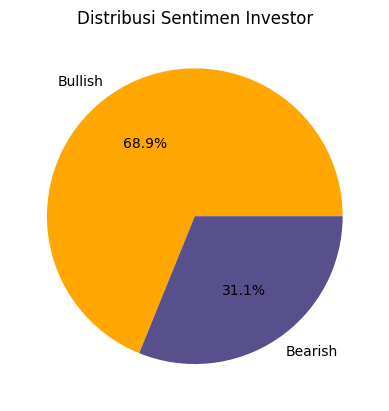

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi Sentimen
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#ffa600', '#58508d'])
plt.title("Distribusi Sentimen Investor")
plt.ylabel("")
plt.show()

Berdasarkan visualisasi data tersebut, dapat ditarik kesimpulan bahwa mayoritas komentar adalah positif dan sentimen adalah bullish

/tmp/ipython-input-19-68967460.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.values, y=top_companies.index, palette="viridis")


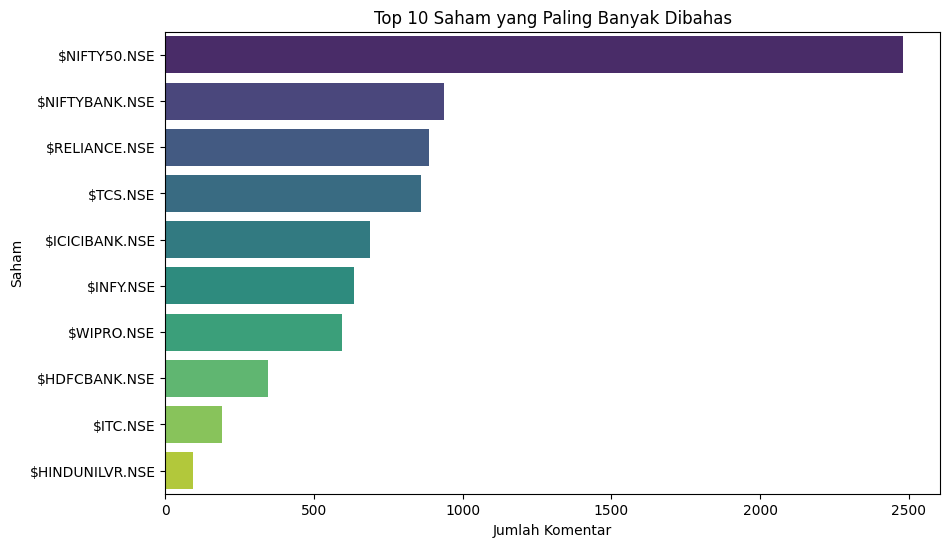

In [19]:
# Top 10 Saham yang Paling Banyak Dibahas
top_companies = df['company'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_companies.values, y=top_companies.index, palette="viridis")
plt.xlabel("Jumlah Komentar")
plt.ylabel("Saham")
plt.title("Top 10 Saham yang Paling Banyak Dibahas")
plt.show()

Berdasarkan data tersebut, Nifty50 sebagai index acuan menjadi yang paling banyak dibicarakan, diikuti oleh index perbankan India, yaitu NiftyBank. Perusahaan paling banyak dibahas adalah Reliance, perusahaan energi.

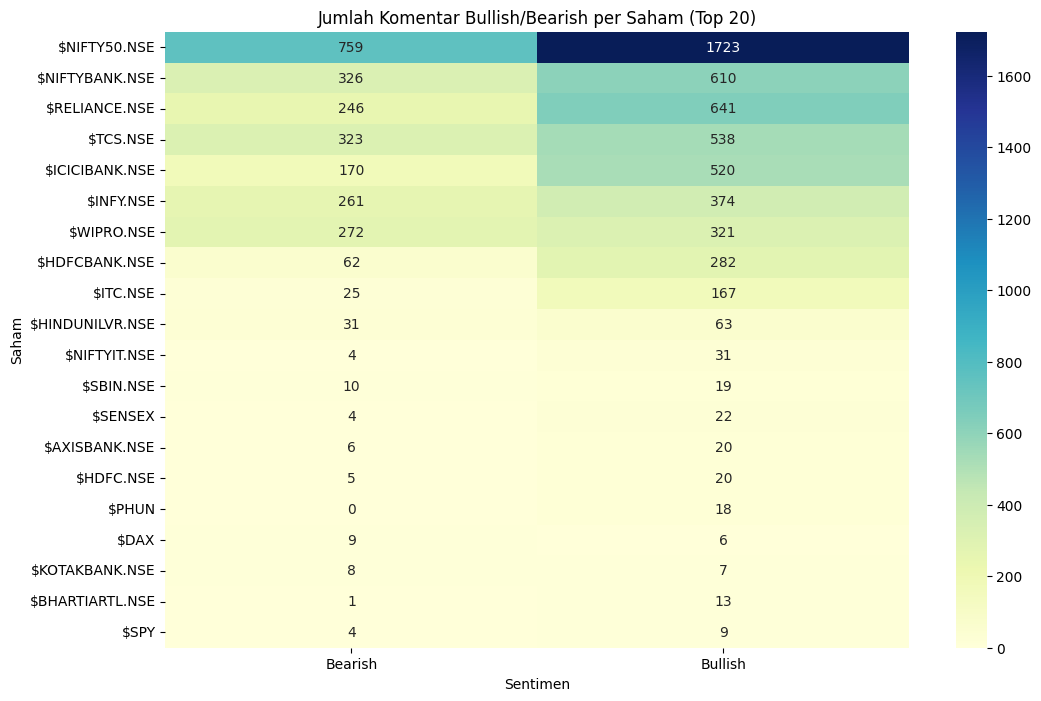

In [20]:
#Jumlah komentar bullish/bearish tiap saham
pivot_df = df.pivot_table(index='company', columns='sentiment', aggfunc='size', fill_value=0)
top20 = pivot_df.sum(axis=1).sort_values(ascending=False).head(20)
heatmap_data = pivot_df.loc[top20.index]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Jumlah Komentar Bullish/Bearish per Saham (Top 20)")
plt.ylabel("Saham")
plt.xlabel("Sentimen")
plt.show()

Beberapa saham sangat condong ke satu sentimen (misal: RELIANCE → sangat bullish). Sedangkan beberapa saham lain, memiliki jumlah komen bullish dan bearish yang setara (misal: KOTAKBANK)

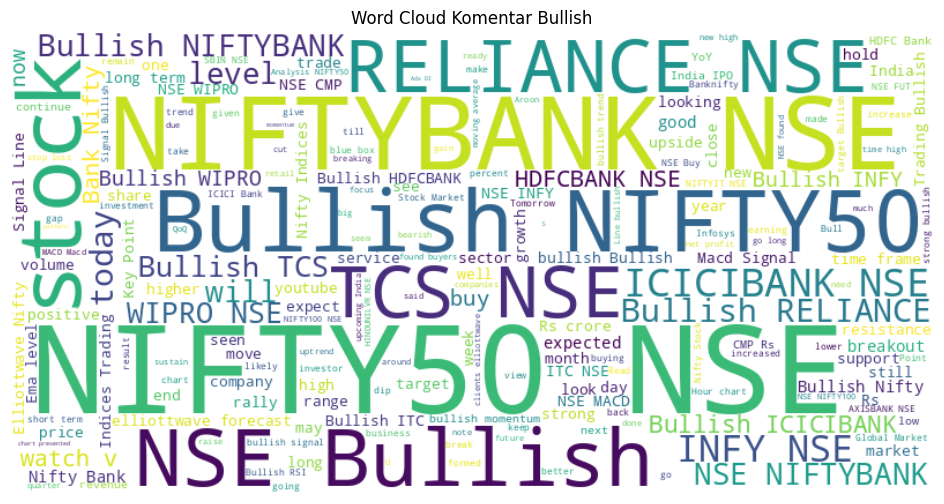

In [22]:
#WordCloud untuk kata-kata yang paling sering muncul
from wordcloud import WordCloud

bullish_text = ' '.join(df[df['sentiment'] == 'Bullish']['tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bullish_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Komentar Bullish")
plt.show()


Kata-kata yang sering muncul di sentimen Bullish

# Prompt

In [7]:
def create_prompt(company, sentiment, tweets):
    return f"""
Berikut adalah kumpulan komentar tweeter tentang saham {company} dengan sentimen {sentiment}.
Buat ringkasan tentang topik utama yang dibahas, dan jelaskan mengapa sentimen ini muncul.

Komentar:
{tweets}
"""


In [8]:
# Proporsi sentimen keseluruhan
total = len(df)
bullish_pct = round(100 * (df['sentiment'] == 'Bullish').sum() / total, 1)
bearish_pct = round(100 * (df['sentiment'] == 'Bearish').sum() / total, 1)
overall_sentiment = "Bullish" if bullish_pct > bearish_pct else "Bearish"

print(bullish_pct)
print(bearish_pct)

68.9
31.1


In [9]:
# Ringkasan alasan umum dari LLM
top_sentiment = "Bullish" if overall_sentiment == "Bullish" else "Bearish"
sentiment_tweets = df[df['sentiment'] == top_sentiment]['tweet'].tolist()[:10]
sentiment_text = "\n- " + "\n- ".join(sentiment_tweets)

sentiment_prompt = f"""
Komentar investor dengan sentimen {top_sentiment}:

{sentiment_text}

Apa alasan utamanya? Ringkas dalam dua kalimat.
"""

sentiment_summary = llm.invoke(sentiment_prompt)

In [10]:
# Ringkasan NIFTY50
nifty_df = df[df['company'].str.upper().str.contains("NIFTY50")]
if not nifty_df.empty:
    nifty_sample = "\n- " + "\n- ".join(nifty_df['tweet'].tolist()[:5])
    nifty_prompt = f"""Berdasarkan tweet $NIFTY50.NSE ini.

{nifty_sample}

Apa sentimen utama investor? Ringkas dalam satu kalimat.
"""
    nifty_summary = llm.invoke(nifty_prompt)
    nifty_sentiment = "Bullish" if (nifty_df['sentiment'] == 'bullish').sum() > (nifty_df['sentiment'] == 'bearish').sum() else "Bearish"
else:
    nifty_summary = "Tidak ada komentar hari ini tentang $NIFTY50.NSE."
    nifty_sentiment = "-"


Indeks Nifty 50 dianalisa pertama karena merupakan salah satu tolok ukur pasar saham terkemuka di India, yang banyak diikuti oleh investor, pedagang, dan analis keuangan. Indeks ini mencerminkan kinerja 50 perusahaan berkapitalisasi besar teratas yang terdaftar di Bursa Efek Nasional (NSE) India.

sumber: www.ebc.com

In [15]:
def get_company_insight(company, retries=2):
    for attempt in range(retries):
        try:
            tweets = df[df['company'] == company]['tweet'].tolist()
            short_tweets = sorted(tweets, key=len)[:5]
            text = "\n- " + "\n- ".join(short_tweets)
            prompt = f"""
Komentar tentang saham {company}:

{text}

Apa insight investor? Jawab singkat dan jelas.
"""
            result = llm.invoke(prompt).strip()
            time.sleep(2)
            return result
        except Exception as e:
            print(f"⚠️ Error {company} (attempt {attempt + 1}):", e)
            time.sleep(5)
    return "Ringkasan tidak tersedia setelah beberapa percobaan."


In [12]:
# Ringkasan Top 3 Ticker Paling Ramai dan Paling Sepi dibicarakan publik

import time
from datetime import datetime

company_counts = df['company'].value_counts()
top3 = company_counts.head(3)
bottom3 = company_counts.tail(3)

top3_insights = []
for comp, count in top3.items():
    insight = get_company_insight(comp)
    top3_insights.append((comp, count, insight))

bottom3_insights = []
for comp, count in bottom3.items():
    insight = get_company_insight(comp)
    bottom3_insights.append((comp, count, insight))

# Market Summary

In [14]:
# Gabungkan Semua ke Summary
tanggal = datetime.today().strftime("%d %B %Y")

final_summary = f"""
📊 Market Summary – {tanggal}

- Today's Market Setiment: **{overall_sentiment}**!!
  Based on total comment percentage: {bullish_pct}% Bullish, {bearish_pct}% Bearish.
  General Reason: {sentiment_summary}

- $NIFTY50.NSE is {nifty_sentiment}
  Insight: {nifty_summary}

- Top 3 most discussed company:
"""
for i, (comp, count, insight) in enumerate(top3_insights, 1):
    final_summary += f"  {i}. {comp} – {count} comment\n     {insight}\n"

final_summary += "\n- Top 3 least discussed company:\n"
for i, (comp, count, insight) in enumerate(bottom3_insights, 1):
    final_summary += f"  {i}. {comp} – {count} comment\n     {insight}\n"

print(final_summary)


📊 Market Summary – 14 July 2025

- Today's Market Setiment: **Bullish**!!
  Based on total comment percentage: 68.9% Bullish, 31.1% Bearish.  
  General Reason: Investor sentiment for $ICICIBANK.NSE is bullish due to consistent rising trend, crossing key moving averages, bullish MACD and RSI in overbought zone, potential for further upside movement past the 950 target, and FPI shareholding remaining stable at 44%.

- $NIFTY50.NSE is Bearish  
  Insight: The predominant investor sentiment, as indicated by the tweets, is a mix of bullish and bearish outlooks. Investors are optimistic about potential rallies in NIFTY50.NSE and positive results from RELIANCE.NSE and ICICIBANK.NSE, yet they remain cautious due to ongoing geo-political tensions, inflation concerns, and rural slowdown, reflected in bearish predictions for NIFTY50.NSE, NIFTYBANK.NSE, and ICICIBANK.NSE. Additionally, bank NPA at a 6-year low is seen as a positive sign.

In a single keyword, the overarching sentiment is "Cautio